# Introduction
CNN's are really good at image recognition. Here we train a standard object recognition test using the cifar10 dataset. First we download the data:

In [1]:
from support_functions import *
%matplotlib inline

#import data (code gegeven)
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


In [1]:
(train_images, train_labels), (test_images, test_labels) = datasets.cifar10.load_data()

print(train_images.shape)
print(train_labels.shape)

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.12) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


170498071/170498071 [==============================] - 160s 1us/step
(50000, 32, 32, 3)
(50000, 1)


So we now have 50k images that each are `32x32` pixels big, and contain 3 color channels (`train_images`). In addition, for each of the images we have the associated label, for example:

In [2]:
train_labels[0:10]

array([[6],
       [9],
       [9],
       [4],
       [1],
       [1],
       [2],
       [7],
       [8],
       [3]], dtype=uint8)

Which shows the code associated with each label. If we inspect the first 25 images:

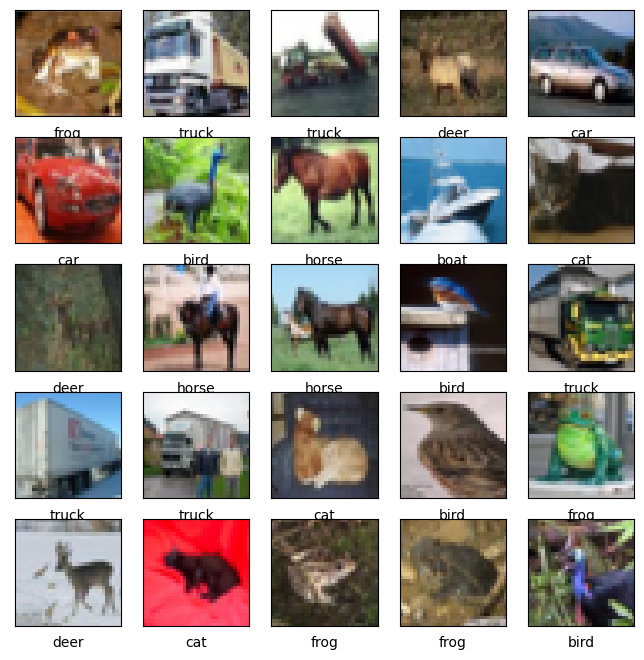

In [4]:
import matplotlib.pyplot as plt

class_names = ['airplane', 'car', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'boat', 'truck']

plt.figure(figsize=(8,8))
for i in range(25):
    plt.subplot(5,5,i+1)  #vul het i-e image
    plt.xticks([]) #geen schaal bij x-as
    plt.yticks([]) #geen schaal bij y-as
    plt.imshow(train_images[i]) 
    plt.xlabel(class_names[train_labels[i][0]]) 

# Running the model locally from VS code
Now we have the data, we can start building a neural network to actually recognize the objects and animals that are in the images. 

In [3]:
import pandas as pd

def plot_accuracy(history):
    return pd.DataFrame({"Accuracy":history.history['accuracy'], 
                         "Validation accuracy":history.history['val_accuracy']}).plot(xlabel = 'Epoch')

Epoch 1/5
1563/1563 [==============================] - 17s 8ms/step - loss: 1.8066 - accuracy: 0.3391 - val_loss: 1.3974 - val_accuracy: 0.5069
Epoch 2/5
1563/1563 [==============================] - 12s 7ms/step - loss: 1.3438 - accuracy: 0.5136 - val_loss: 1.0787 - val_accuracy: 0.6125
Epoch 3/5
1563/1563 [==============================] - 12s 7ms/step - loss: 1.1470 - accuracy: 0.6007 - val_loss: 0.9849 - val_accuracy: 0.6758
Epoch 4/5
1563/1563 [==============================] - 12s 7ms/step - loss: 1.0190 - accuracy: 0.6496 - val_loss: 0.8019 - val_accuracy: 0.7188
Epoch 5/5
1563/1563 [==============================] - 12s 8ms/step - loss: 0.9165 - accuracy: 0.6891 - val_loss: 0.8373 - val_accuracy: 0.7202


<AxesSubplot:xlabel='Epoch'>

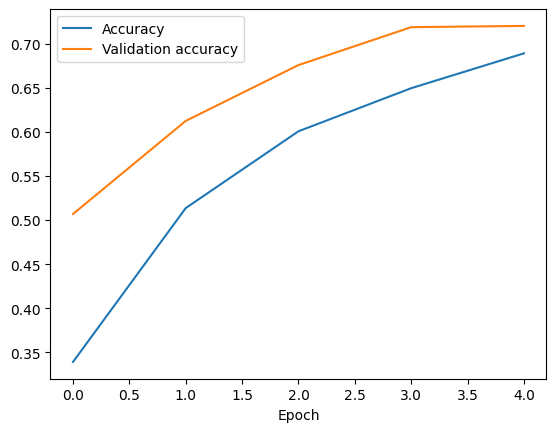

In [4]:
from keras.preprocessing.image import ImageDataGenerator

train_images, test_images = train_images / 255.0, test_images / 255.0

train_datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
)

data_flow = train_datagen.flow(train_images, tf.reshape(train_labels, (-1)), shuffle=True)

model = models.Sequential([
    layers.Conv2D(32, (3,3) , activation="relu", input_shape=(32,32,3), padding='same') , 
    layers.BatchNormalization(),
    layers.Conv2D(32, (3,3) , activation="relu", padding='same') ,
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.2),
    layers.Conv2D(64, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.Conv2D(64, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),
    layers.Conv2D(128, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.Conv2D(128, (3,3) , activation="relu", padding='same') , 
    layers.BatchNormalization(),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.4),
    layers.Flatten(),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.5),
    layers.Dense(10, activation="softmax")
])
model.compile(optimizer="ADAM",
            loss="sparse_categorical_crossentropy",
            metrics=["accuracy"])

history=model.fit(train_images, train_labels, epochs=5, batch_size=32, validation_data=(test_images, test_labels))

plot_accuracy(history)

Notice that training this takes quite a while, so for longer training sessions we prefer to use a training script (`train_mlflow.py`) and run it on a much more powerful remote server. After running the experiments you wanted, you need to copy over the `mlruns` directory manually from the server to the working directory here locally. All further code assumes you did this. 

# Interpreting the results of the experiments
We ran the experiments on the server using MLFlow, which now allows us to explore those. The best way to visually explore the results is using `mlflow ui`, but here we manually load the data from the runs. Note that MLFlow has two concepts that are important here:

- A run is one run of a particular model using particluar settings
- An experiment is a set of runs that all take place in the same experiment. 

In this case, we have one experiment (detect objects) and multiple runs within that experiment. Using `search_runs` we list the runs of all experiments:

In [21]:
import mlflow

available_runs = mlflow.search_runs()
available_runs.columns

Index(['run_id', 'experiment_id', 'status', 'artifact_uri', 'start_time',
       'end_time', 'metrics.val_loss', 'metrics.loss', 'metrics.val_accuracy',
       'metrics.accuracy', 'params.initial_epoch', 'params.workers',
       'params.validation_batch_size', 'params.opt_epsilon',
       'params.opt_beta_2', 'params.validation_freq',
       'params.opt_learning_rate', 'params.steps_per_epoch',
       'params.use_multiprocessing', 'params.sample_weight', 'params.opt_name',
       'params.epochs', 'params.class_weight', 'params.opt_amsgrad',
       'params.validation_split', 'params.shuffle', 'params.opt_beta_1',
       'params.validation_steps', 'params.batch_size', 'params.opt_decay',
       'params.max_queue_size', 'tags.mlflow.runName',
       'tags.mlflow.source.name', 'tags.mlflow.source.type',
       'tags.mlflow.log-model.history', 'tags.mlflow.user'],
      dtype='object')

In [22]:
import pickle

def get_mlruns_pickle(run_row, fname, vars2get=['experiment_id', 'run_id']):
    with open('mlruns/%s/%s/artifacts/%s' % (run_row['experiment_id'], run_row['run_id'], fname), 'rb') as hist_file:
        f = pickle.load(hist_file)
    ret_dict = {'data': f}
    for var in vars2get:
        ret_dict[var] = run_row[var]
    return ret_dict

all_history = [get_mlruns_pickle(run_row, 'history.pkl', 
                                 vars2get=['experiment_id', 'run_id', 'params.opt_learning_rate', 'params.batch_size']) 
                                   for idx, run_row in available_runs.iterrows()]

In [56]:
import numpy as np

all_acc_data = pd.concat([pd.DataFrame({'accuracy': h['data'].history['accuracy'],
                                        'val_accuracy': h['data'].history['val_accuracy'],
                                        'experiment_id': h['experiment_id'],
                                        'run_id': h['run_id'],
                                        'learning_rate': h['params.opt_learning_rate'],
                                        'batch_size': h['params.batch_size'], 
                                        'epoch': range(len(h['data'].history['accuracy']))}) for h in all_history])
plot_data = all_acc_data.melt(value_vars=['accuracy', 'val_accuracy'], id_vars=['experiment_id', 'run_id', 'epoch', 'learning_rate', 'batch_size'])

lr_series = pd.to_numeric(plot_data['learning_rate'])
plot_data['learning_rate'] = pd.Categorical(lr_series, lr_series.unique())

btsize_series = pd.to_numeric(plot_data['batch_size'])
plot_data['batch_size'] = pd.Categorical(btsize_series, btsize_series.unique())

with open('plot_data_sens.pkl', 'wb') as pkl_file:
    pickle.dump(plot_data, pkl_file)

plot_data.head()

,experiment_id,run_id,epoch,learning_rate,batch_size,variable,value
0,0,bf70db28c49f40109789439c281b035f,0,0.000001,2048,accuracy,0.09928
1,0,bf70db28c49f40109789439c281b035f,1,0.000001,2048,accuracy,0.10168
2,0,bf70db28c49f40109789439c281b035f,2,0.000001,2048,accuracy,0.10266
3,0,bf70db28c49f40109789439c281b035f,3,0.000001,2048,accuracy,0.10364
4,0,bf70db28c49f40109789439c281b035f,4,0.000001,2048,accuracy,0.10374


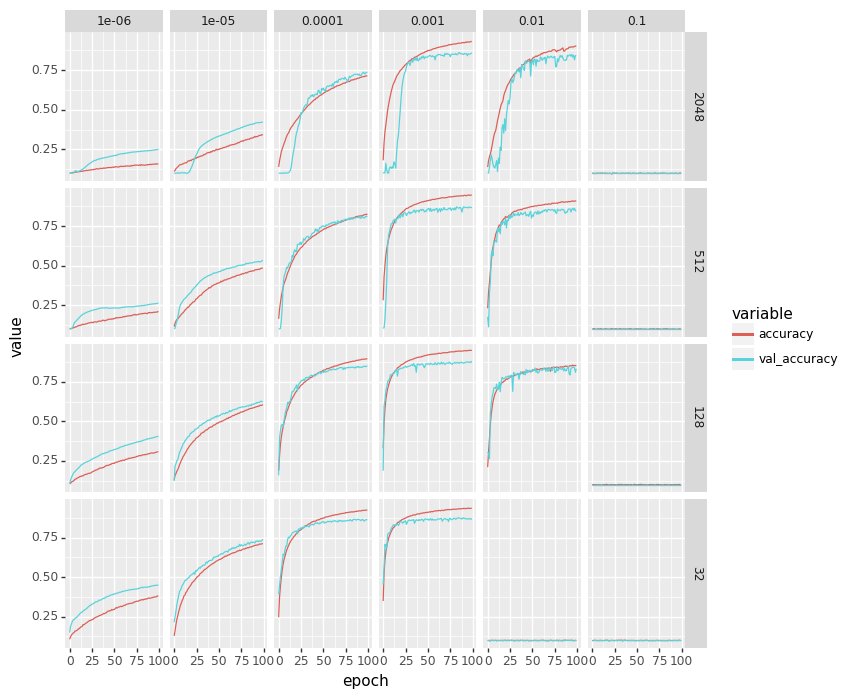

<ggplot: (8735253600561)>

In [57]:
from plotnine import *

(
    ggplot(plot_data) + geom_line(aes(x='epoch', y='value', color='variable')) + facet_grid('batch_size ~ learning_rate') + theme(figure_size=(8,8))
)